## Khai báo thư viện

In [1]:
import os
import re
import nltk
import time
import email
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
nltk.download('stopwords')
warnings.filterwarnings('ignore')
np.random.seed(49)

# Đường dẫn thư mục
spam_path = r'D:\data\spam_2\spam_2'
easy_ham_path = r'D:\data\easy_ham\easy_ham'
hard_ham_path = r'D:\data\hard_ham\hard_ham'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Đọc dữ liệu từ thư mục 

In [2]:
def get_data(path):
    data = []
    # Get the files from the path 
    files = Path(path).glob('*') # .rglob to get subdirectories
    for file in files:
        f=open(file,encoding = "ISO-8859-1")
        word_list=f.read()
        data.append(word_list)
        f.close()
    return data

In [3]:
# Đọc dữ liệu từ các thư mục và gán cho các list tương ứng
# ham là tập thư non-spam
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)

In [4]:
test_email_string = ham[3]

In [5]:
print(test_email_string)

From irregulars-admin@tb.tf  Thu Aug 22 14:23:39 2002
Return-Path: <irregulars-admin@tb.tf>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9DAE147C66
	for <zzzz@localhost>; Thu, 22 Aug 2002 09:23:38 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:23:38 +0100 (IST)
Received: from web.tb.tf (route-64-131-126-36.telocity.com
    [64.131.126.36]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id
    g7MDGOZ07922 for <zzzz-irr@example.com>; Thu, 22 Aug 2002 14:16:24 +0100
Received: from web.tb.tf (localhost.localdomain [127.0.0.1]) by web.tb.tf
    (8.11.6/8.11.6) with ESMTP id g7MDP9I16418; Thu, 22 Aug 2002 09:25:09
    -0400
Received: from red.harvee.home (red [192.168.25.1] (may be forged)) by
    web.tb.tf (8.11.6/8.11.6) with ESMTP id g7MDO4I16408 for
    <irregulars@tb.tf>; Thu, 22 Aug 200

# 2. Phân tích dữ liệu

In [6]:
print("Easy ham:",len(easy_ham))
print("Hard ham:",len(hard_ham))
print("Ham:",len(ham))
print("Ham+Spam:",len(ham+spam))
print("Spam:",len(spam))
print("Percentage of spam email:",len(spam)/(len(spam)+len(ham))*100)

Easy ham: 2551
Hard ham: 250
Ham: 2801
Ham+Spam: 4198
Spam: 1397
Percentage of spam email: 33.27775131014769


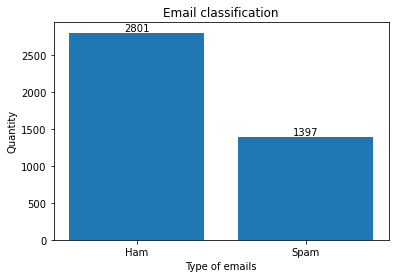

In [7]:
email_categories = ['Ham', 'Spam']
email_counts = [len(ham), len(spam)]
import matplotlib.pyplot as plt
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+20, y[i], ha = 'center')
plt.bar(email_categories, email_counts)
plt.title('Email classification')
plt.xlabel('Type of emails')
plt.ylabel('Quantity')
addlabels(email_categories, email_counts)
plt.show()

Text(0.5, 1.0, 'Average of Email')

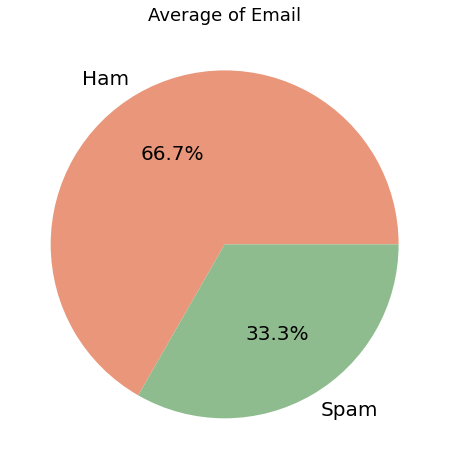

In [8]:
plt.figure(figsize=(16, 8))
plt.pie(email_counts,
        labels = email_categories, # Nhãn của các nhóm
        colors = ['#E9967A', '#8FBC8F'], # Màu sắc của các nhóm
        autopct = '%1.1f%%', # Format hiển thị giá trị %
        shadow = False,
        textprops={'fontsize': 20})
plt.title("Average of Email", fontsize=18)

In [9]:
# Message_from_string là hàm chuyển từ dạng String sang dạng email
test_email=email.message_from_string(test_email_string)

In [10]:
# Get_content_type là hàm trả về dạng email
test_email.get_content_type()

'text/plain'

In [11]:
print("Header fields: ", test_email.keys())
print("Field values: ", test_email.values())
print("Email content: ", test_email.get_payload())

Header fields:  ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'MIME-Version', 'X-Sender', 'Message-Id', 'To', 'From', 'Content-Type', 'Subject', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'Date']
Field values:  ['<irregulars-admin@tb.tf>', 'zzzz@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9DAE147C66\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 09:23:38 -0400 (EDT)', 'from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:23:38 +0100 (IST)', 'from web.tb.tf (route-64-131-126-36.telocity.com\n    [64.131.126.36]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id\n    g7MDGOZ07922 for <zzzz-irr@example.com>; Thu, 22 Aug 2002 14:16:24 +0100', 'from web.tb

In [12]:
ham_emails = []
spam_emails = []

# Hàm này chuyển một list String sang dạng một list emails
def parse_email(emails):
    list = []
    for mail in emails:
        a = email.message_from_string(mail)
        list.append(a)
    return list

ham_emails = parse_email(ham)
spam_emails = parse_email(spam)

In [13]:
multi_email = None

# Tìm một email có dạng multipart gán cho biến multi_email
for mail in ham_emails:
    if mail.is_multipart():
        multi_email = mail
        break

In [14]:
# In ra phần thứ nhất của multipart email
print(multi_email.get_payload()[0].get_payload())

> From:  "J. W. Ballantine" <jwb@homer.att.com>
> Date:  Wed, 21 Aug 2002 09:51:31 -0400
>
> I CVS'ed the unseen/Sequences changes and installed them, and have only one 
> real issue.
> 
> I use the unseen window rather than the exmh icon, and with the new code
> I can't seem to be able to.  How many unseen when when I have the main window open
> is not really necessary.

hmmm, I stole the code from unseenwin, but I never tested it since I don't use 
that functionality.  Consider it on my list of things to check.

Chris

-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin, TX  78701		+1 512 374 0500

  World War III:  The Wrong-Doers Vs. the Evil-Doers.






In [15]:
# In ra phần thứ hai của multipart email
print(multi_email.get_payload()[1].get_payload())

-----BEGIN PGP SIGNATURE-----
Version: GnuPG v1.0.6 (GNU/Linux)
Comment: Exmh version 2.2_20000822 06/23/2000

iD8DBQE9ZPFAK9b4h5R0IUIRAkjyAJ4jjjhAVRx5FiwuCMa+QBWsbbE2jQCaAj4x
NhIgYqnx9/1wvdSgesQhMIU=
=vA3k
-----END PGP SIGNATURE-----



In [16]:
# Hàm get_structure được sử dụng để lấy định dạng của email là single/multipart
def get_structure(email) -> str:
    # Lẩy nội dung email qua hàm get_payload()
    payload = email.get_payload()
    # Nếu nội dung email có dạng list thì tiếp tục gọi đệ quy đến từng phần của nó
    if isinstance(payload, list):
        return "multipart({})".format(", ".join(
            get_structure(message)
            for message in payload
        ))
    else:
    # Nếu không thì trả về dạng email của nó
        return email.get_content_type()

In [17]:
get_structure(test_email)

'text/plain'

In [18]:
get_structure(multi_email)

'multipart(text/plain, application/pgp-signature)'

In [19]:
# Hàm này được sử dụng để đếm tất cả dạng cấu trúc email có trong một mảng emails
def email_structure_counter(emails):
    structs = Counter()
    for mail in emails:
        mail_struct = get_structure(mail)
        structs[mail_struct] += 1
    return structs

ham_structs = email_structure_counter(ham_emails)
spam_structs = email_structure_counter(spam_emails)

In [20]:
# Những dạng cáu trúc email phô biến nhất có trong tập ham emails
ham_structs.most_common()

[('text/plain', 2539),
 ('text/html', 120),
 ('multipart(text/plain, application/pgp-signature)', 72),
 ('multipart(text/plain, text/html)', 46),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, application/x-pkcs7-signature)', 2),
 ('multipart(text/html)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1),
 ('multipart(text/plain, image/png, image/png)', 1

In [21]:
#Hàm vẽ ra cấu trúc phổ biến của email
def draw_wordcloud(structs): 
    wordcloud = WordCloud(width=1600, height=800, random_state=3301)
    wordcloud.generate_from_frequencies(frequencies=structs)

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

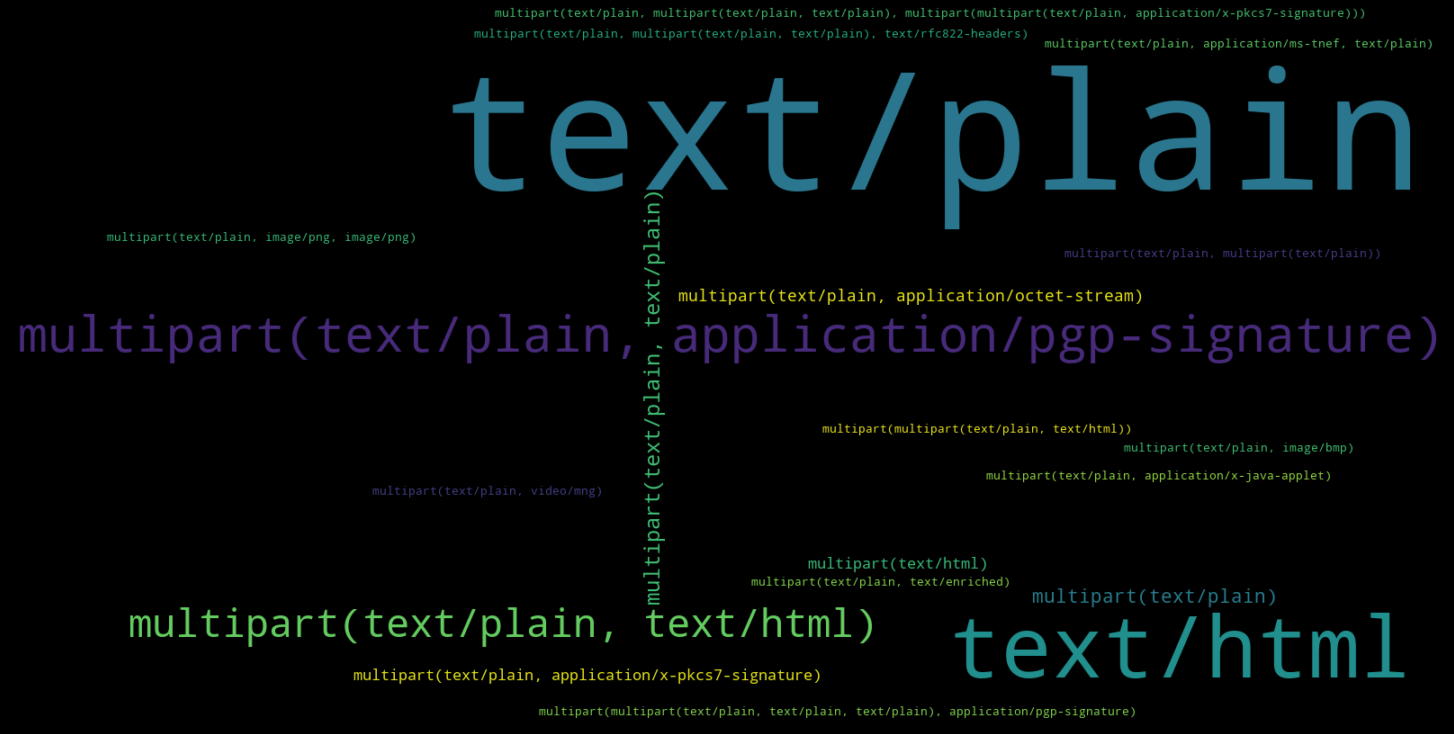

[('text/plain', 2539),
 ('text/html', 120),
 ('multipart(text/plain, application/pgp-signature)', 72),
 ('multipart(text/plain, text/html)', 46),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, application/x-pkcs7-signature)', 2),
 ('multipart(text/html)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1),
 ('multipart(text/plain, image/png, image/png)', 1

In [22]:
# Những dạng cấu trúc email phô biến nhất có trong tập ham emails
draw_wordcloud(ham_structs)
ham_structs.most_common()

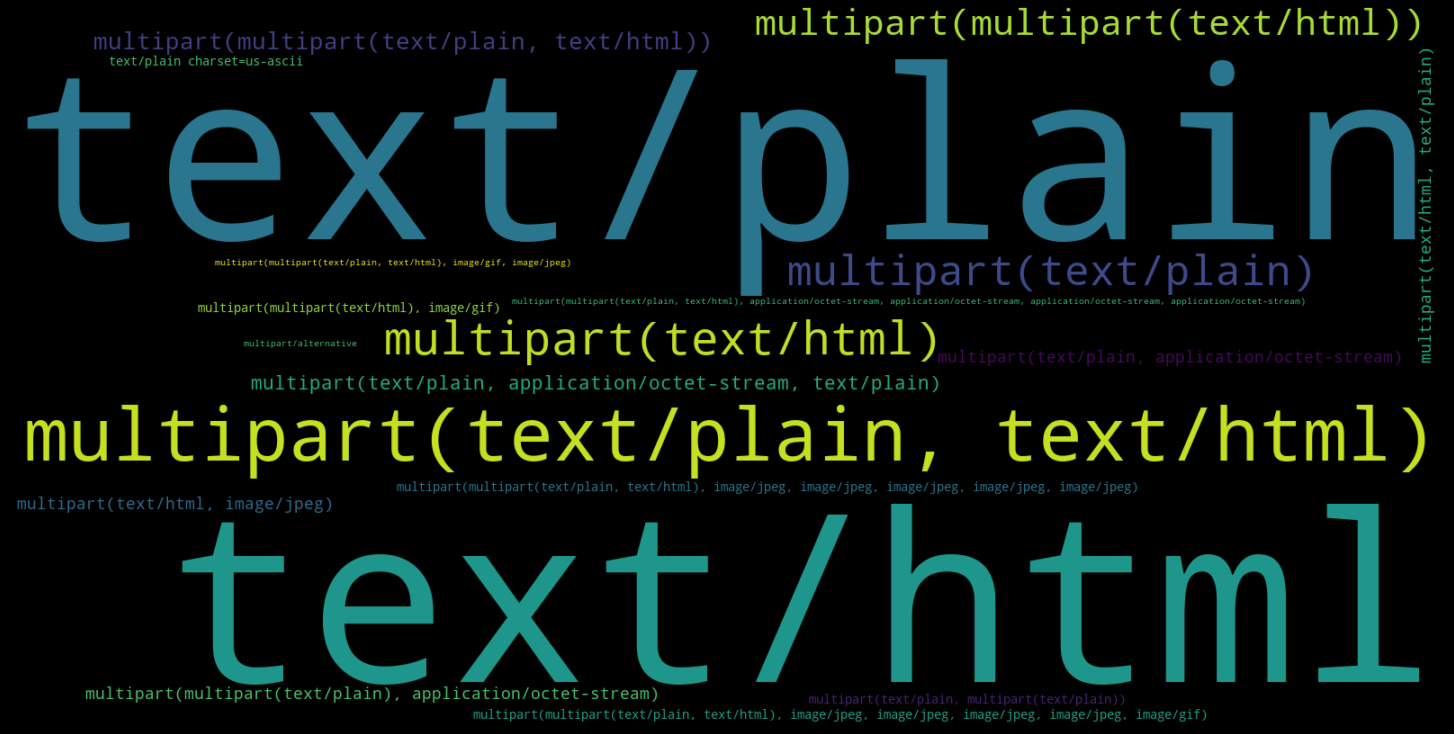

[('text/plain', 598),
 ('text/html', 589),
 ('multipart(text/plain, text/html)', 114),
 ('multipart(text/html)', 29),
 ('multipart(text/plain)', 25),
 ('multipart(multipart(text/html))', 18),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart(text/html, text/plain)', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/gif)',
  1),
 ('text/plain charset=us-ascii', 1),
 ('multipart(multipart(text/html), image/gif)', 1),
 ('multipart(multipart(text/plain, text/html), application/octet-stream, application/octet-stream, applic

In [23]:
# Những dạng cấu trúc email phô biến nhất có trong tập ham emails

draw_wordcloud(spam_structs)
spam_structs.most_common()

# 3. Làm sạch dữ liệu

In [24]:
html_email = None
# Lấy ra một html email và in ra nội dung của nó
for email in spam_emails:
    if get_structure(email) == 'text/html':
        html_email = email
        break

print(html_email.get_payload())

<html>
<body>
<center>
<h3>
<font color="blue">
<b>
The Need For Safety Is Real In 2002, You Might Only Get One Chance - Be Ready!
<p>
Free Shipping & Handling Within The (USA) If You Order Before May 25, 2002! 
<p>
3 Day Super Sale, Now Until May 7, 2002!  Save Up To $30.00 On Some Items!

</b>
</font>
</h3>
</center>
<p>
IT'S GETTING TO BE SPRING AGAIN, PROTECT YOURSELF AS YOU WALK,<br>
JOG AND EXERCISE OUTSIDE.  ALSO PROTECT YOUR LOVED ONES AS<br>
THEY RETURN HOME FROM COLLEGE!<br>
<p>
*     LEGAL PROTECTION FOR COLLEGE STUDENTS!<br>
*     GREAT UP'COMING OUTDOOR PROTECTION GIFTS!<br>
*     THERE IS NOTHING WORTH MORE PROTECTING THAN LIFE!<br>
*     OUR STUN DEVICES & PEPPER PRODUCTS ARE LEGAL PROTECTION!
<p>
<b>
<font color="red">
JOIN THE WAR ON CRIME!
</b>
</font>
<p>

STUN GUNS AND BATONS 
<p>
EFFECTIVE - SAFE - NONLETHAL
<p>
PROTECT YOUR LOVED ONES AND YOURSELF
<p>
No matter who you are, no matter what City or Town you live in,<br>
if you live in America, you will be touched by

In [25]:
# Hàm chuyển HTML email về dạng Plain/text email
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [26]:
print(html_to_text(html_email))

The Need For Safety Is Real In 2002, You Might Only Get One Chance - Be Ready! Free Shipping & Handling Within The (USA) If You Order Before May 25, 2002! 3 Day Super Sale, Now Until May 7, 2002! Save Up To $30.00 On Some Items! IT'S GETTING TO BE SPRING AGAIN, PROTECT YOURSELF AS YOU WALK, JOG AND EXERCISE OUTSIDE. ALSO PROTECT YOUR LOVED ONES AS THEY RETURN HOME FROM COLLEGE! * LEGAL PROTECTION FOR COLLEGE STUDENTS! * GREAT UP'COMING OUTDOOR PROTECTION GIFTS! * THERE IS NOTHING WORTH MORE PROTECTING THAN LIFE! * OUR STUN DEVICES & PEPPER PRODUCTS ARE LEGAL PROTECTION! JOIN THE WAR ON CRIME! STUN GUNS AND BATONS EFFECTIVE - SAFE - NONLETHAL PROTECT YOUR LOVED ONES AND YOURSELF No matter who you are, no matter what City or Town you live in, if you live in America, you will be touched by crime. You hear about it on TV. You read about it in the newspaper. It's no secret that crime is a major problem in the U.S. today. Criminals are finding it easier to commit crimes all the time. Weapons

In [27]:
# Hàm thực hiện việc chuyển định dạng email về dạng Plain text
def email_to_text(email):
    text_content = ""
    # Duyệt qua từng phần của email
    for part in email.walk():
        # Lấy dạng cấu trúc của phần đó
        part_content_type = part.get_content_type()
        # Nếu không thuộc dạng text/plain hay text/html thì bỏ qua
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        # Nếu thuộc dạng text/plain thì thêm giá trị phần đó vào kết quả
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        # Nếu thuộc dạng text/html thì chuyển phần đó về dạng text/plain rồi thêm vào kết quả
        else:
            text_content += html_to_text(part)
    # Trả về kết quả
    return text_content

In [28]:
# Phần tử dữ liệu khi chưa được xử lí
ham[3]

'From irregulars-admin@tb.tf  Thu Aug 22 14:23:39 2002\nReturn-Path: <irregulars-admin@tb.tf>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9DAE147C66\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 09:23:38 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:23:38 +0100 (IST)\nReceived: from web.tb.tf (route-64-131-126-36.telocity.com\n    [64.131.126.36]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id\n    g7MDGOZ07922 for <zzzz-irr@example.com>; Thu, 22 Aug 2002 14:16:24 +0100\nReceived: from web.tb.tf (localhost.localdomain [127.0.0.1]) by web.tb.tf\n    (8.11.6/8.11.6) with ESMTP id g7MDP9I16418; Thu, 22 Aug 2002 09:25:09\n    -0400\nReceived: from red.harvee.home (red [192.168.25.1] (may be forged)) by\n    web.tb.tf (8.11.6/8.11.6) with ESMTP id g7MDO4I16408 for\n    <irregulars@t

In [29]:
# Phần tử dữ liệu đẫ qua xử lí
print("Ham email in plain text:\n", email_to_text(ham_emails[3]))

Ham email in plain text:
 Klez: The Virus That Won't Die
 
Already the most prolific virus ever, Klez continues to wreak havoc.

Andrew Brandt
>>From the September 2002 issue of PC World magazine
Posted Thursday, August 01, 2002


The Klez worm is approaching its seventh month of wriggling across 
the Web, making it one of the most persistent viruses ever. And 
experts warn that it may be a harbinger of new viruses that use a 
combination of pernicious approaches to go from PC to PC.

Antivirus software makers Symantec and McAfee both report more than 
2000 new infections daily, with no sign of letup at press time. The 
British security firm MessageLabs estimates that 1 in every 300 
e-mail messages holds a variation of the Klez virus, and says that 
Klez has already surpassed last summer's SirCam as the most prolific 
virus ever.

And some newer Klez variants aren't merely nuisances--they can carry 
other viruses in them that corrupt your data.

...

http://www.pcworld.com/news/articl

# 4. Tiền xử lí dữ liệu

In [30]:
# Hàm này thực hiện công việc chuyển một plain text thành một danh sách từ ngữ tách biệt có dạng:
# (VD: "hello","world","machine","learning",...)
def textemail_to_cleanwords(plain):
    # Nếu plain text trống
    if plain is None:
        plain = "nothing"
            
    # Chuyển chữ cái trong plain text về dạng chữ thường không in hoa
    plain = plain.lower()
    
    # Bỏ HTML tags
    plain = re.compile('<.*?>').sub(r'', plain)
            
    # Bỏ url trong plain text
    plain = re.sub('http[s]?://\S+', '', plain)
            
    # Bỏ đi các chữ số trong plain text 
    pattern = '[0-9]'
    plain = re.sub(pattern, '',plain)
            
    # Bỏ đi dấu trong plain text
    plain = plain.replace(".", "")
    plain = plain.replace(",", "")
    plain = plain.replace("!", "")
    plain = plain.replace("?", "")
    plain = plain.replace(";", "")
    plain = plain.replace("&", "")
    plain = plain.replace("$", "")
    plain = plain.replace("_", "")
    plain = plain.replace("*", "")
    plain = plain.replace("-", "")
    plain = plain.replace("=", "")
    plain = plain.replace("'", "")
    plain = plain.replace("(", "")

    # Bỏ stopwords trong plain text và chuyển nó thành một danh sách từ
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in plain.split() if not word.lower() in stop_words]
    #Stemming
    clean_words = [PorterStemmer().stem(w) for w in clean_words ]
        
    return clean_words

In [31]:
# Chuẩn bị tập dữ liệu train và test
X = []
for email in spam_emails:
    X.append(email_to_text(email))
for email in ham_emails:
    X.append(email_to_text(email))

In [32]:
# Chuyển tập dữ liệu về dạng vector từ 
X = CountVectorizer(analyzer=textemail_to_cleanwords).fit_transform(X)

In [33]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [34]:
X.shape

(4198, 54405)

In [35]:
print(X[0])

  (0, 23720)	1
  (0, 40832)	7
  (0, 29838)	4
  (0, 20371)	1
  (0, 27376)	1
  (0, 27058)	6
  (0, 36037)	2
  (0, 10852)	1
  (0, 36187)	1
  (0, 19766)	1
  (0, 38379)	2
  (0, 5208)	1
  (0, 44132)	1
  (0, 6989)	1
  (0, 36024)	1
  (0, 31219)	1
  (0, 41282)	1
  (0, 34403)	1
  (0, 53009)	3
  (0, 10830)	1
  (0, 9183)	1
  (0, 8143)	1
  (0, 33787)	2
  (0, 31673)	3
  (0, 33029)	8
  :	:
  (0, 20341)	1
  (0, 47278)	1
  (0, 45638)	1
  (0, 5962)	2
  (0, 31895)	1
  (0, 6413)	2
  (0, 32272)	1
  (0, 6446)	1
  (0, 14008)	1
  (0, 31559)	1
  (0, 35477)	1
  (0, 43539)	1
  (0, 52098)	1
  (0, 18190)	1
  (0, 32381)	1
  (0, 14239)	1
  (0, 45088)	1
  (0, 27685)	1
  (0, 30200)	1
  (0, 49962)	1
  (0, 23791)	1
  (0, 26554)	1
  (0, 49281)	1
  (0, 31425)	1
  (0, 30285)	1


In [36]:
# Tạo một mảng gồm số số 0 là len(spam_emails) và số số 1 là len(ham_emails) để gán nhãn cho các email
y = np.array([0] * len(spam_emails) + [1] * len(ham_emails))

In [37]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
# Phân chia tập train và test là 0,8 và 0,2 và xáo trộn vị trí của các phần tử trong tập dữ liệu
X_train,X_test,y_train,y_test = train_test_split(X , y , test_size = 0.20, shuffle=True, random_state=3000)

# 5. Huấn luyện mô hình

In [39]:
# Huấn luyện cho model với phương pháp phân lớp Naive Bayes
classifier = MultinomialNB().fit(X_train,y_train)

In [40]:
model = MLPClassifier()
X, y = load_iris(return_X_y=True)
start = time.time()
model.fit(X, y)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 0.13367342948913574s


In [41]:
# In ra dự đoán của model và nhãn lớp đúng của nó
print(classifier.predict(X_test))
print("\n")
print(y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0
 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0
 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1
 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0
 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0
 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1
 0 1 1 1 1 0 0 1 1 1 0 1 

# 6. Đánh giá hiệu năng mô hình

In [42]:
# In ra báo cáo đánh giá hiệu năng model
pred = classifier.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       269
           1       0.99      0.99      0.99       571

    accuracy                           0.99       840
   macro avg       0.99      0.98      0.98       840
weighted avg       0.99      0.99      0.99       840



In [43]:
#in ra confusion matrix
print("Confusion matrix: \n", confusion_matrix(y_test,pred))

Confusion matrix: 
 [[261   8]
 [  3 568]]


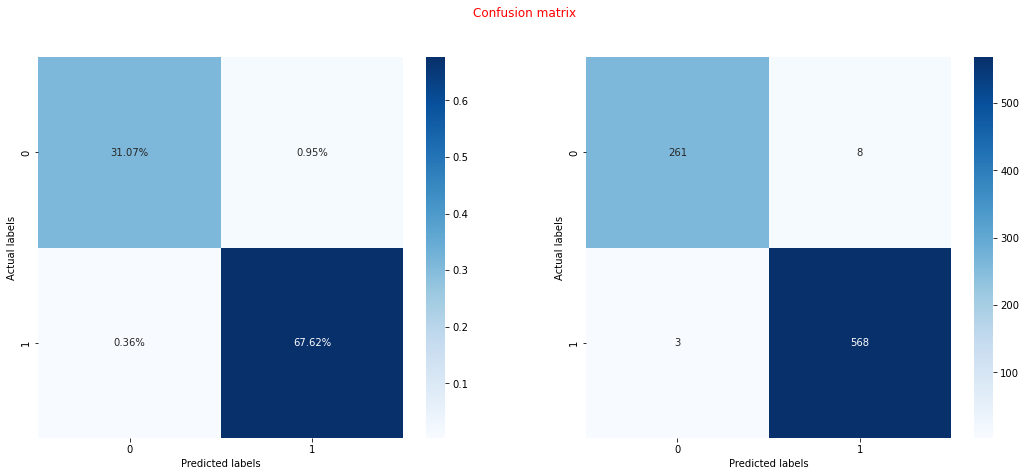

In [44]:
conf_mx = confusion_matrix(y_test,pred)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')

sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()

In [45]:
print("Accuracy: ", accuracy_score(y_test,pred))

Accuracy:  0.986904761904762
